# To-do 
- Debug Boltzmann reweighting so expectation is properly calculated. I believe the energy needs to be regularized as they described on pg. 3 of the SI.  
- Debug/Optimize Metropolis Monte Carlo step during training by energy. This may also not be working due to extremely high energy values (so energy regularization could also help here). 
- Generally optimize methods in net.py (several redundant calls) 
- (quick and easy) generalize energy functions (they need to expect PyTorch tensors instead of numpy arrays). So for example every `np.sum()` should be `torch.sum()`, etc. 

# Setup

In [13]:
import os
import sys
sys.path.insert(0, os.path.join(os.getcwd(), ".."))

import torch
from torch import distributions
from torch import nn
from torch.utils import data
from sklearn import datasets

import random
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
%matplotlib inline
%load_ext autoreload
%autoreload 2 # Reload all modules every time before executing the Python code typed.

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
from project.models.ising import IsingModel
import project.networks.net as net

In [15]:
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
random.seed(0)

# Define Ising Model

CPU times: user 303 µs, sys: 1 µs, total: 304 µs
Wall time: 307 µs


0.1875

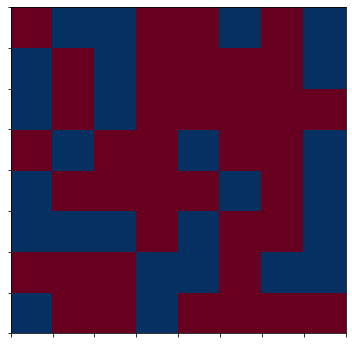

In [16]:
h = 0.0
J = 0.8
T = 1.0
N = 8

ising = IsingModel(h = h, J = J)
x0 = ising.init_coords(N)
ising.draw_config(x0)

%time ising.energy(torch.from_numpy(x0)) # energy of a given configuration 
ising.oprm(x0) # calculate average magnetization 

## Create training set
We'd like to have a $m$ x $N$ matrix containing our training data where $m$ is the number of realizations of the system and $N$ is the number of features (i.e. the flattened dimensions of the system). For example, a training set with 1000 samples of the Ising Model for $N=8$ would be of size (1000, 64). 

In [17]:
num_samples = 128 # Use 1000 at run-time as done in Noe et al. for the biwell potential 
flattened_size = N**2

training_set = np.zeros((num_samples,flattened_size), dtype=np.float32)
for i in range(num_samples):
    training_set[i,:] = ising.init_coords(N).flatten() # generate random configuration 
training_set = torch.from_numpy(training_set) # convert to PyTorch tensor 

As an aside, note that although we flatten our configurations for training, the flattening procedure can easily be reversed via the `rehsape()` function: 

In [18]:
np.array(x0)

array([[-1,  1,  1, -1,  1,  1,  1,  1],
       [ 1,  1,  1, -1, -1,  1, -1, -1],
       [-1, -1, -1,  1, -1,  1,  1, -1],
       [-1,  1,  1,  1,  1, -1,  1, -1],
       [ 1, -1,  1,  1, -1,  1,  1, -1],
       [-1,  1, -1,  1,  1,  1,  1,  1],
       [-1,  1, -1,  1,  1,  1,  1, -1],
       [ 1, -1, -1,  1,  1, -1,  1, -1]])

In [19]:
np.array(x0).flatten().reshape((N,N))

array([[-1,  1,  1, -1,  1,  1,  1,  1],
       [ 1,  1,  1, -1, -1,  1, -1, -1],
       [-1, -1, -1,  1, -1,  1,  1, -1],
       [-1,  1,  1,  1,  1, -1,  1, -1],
       [ 1, -1,  1,  1, -1,  1,  1, -1],
       [-1,  1, -1,  1,  1,  1,  1,  1],
       [-1,  1, -1,  1,  1,  1,  1, -1],
       [ 1, -1, -1,  1,  1, -1,  1, -1]])

# Boltzmann generator
## Define network architecture 
In the following we use 3 hidden layers for the translation and scaling networks and a total of four stacked RealNVP blocks (as defined by `masks`). 

In [20]:
n_hidden = 100 # number of hidden layers
nets = lambda: nn.Sequential(nn.Linear(N**2, n_hidden), nn.Tanh(), nn.Linear(n_hidden, n_hidden), nn.Tanh(), nn.Linear(n_hidden, N**2), nn.Tanh()) # net s
nett = lambda: nn.Sequential(nn.Linear(N**2, n_hidden), nn.ReLU(), nn.Linear(n_hidden, n_hidden), nn.ReLU(), nn.Linear(n_hidden, N**2)) # net t

first_mask = np.array(np.concatenate((np.ones(round(N**2/2)), np.zeros(round(N**2/2)))))
masks_np = np.stack((first_mask, np.flip(first_mask),first_mask,np.flip(first_mask),first_mask, np.flip(first_mask),first_mask, np.flip(first_mask))) 
masks = torch.from_numpy(masks_np.astype(np.float32))

prior = distributions.MultivariateNormal(torch.zeros(N**2), torch.eye(N**2))      # so we have a total of 3 neural blocks (see fig. 1 of boltzmann generators paper)
network = net.RealNVP(nets, nett, masks, prior, ising, x0.shape)

# network.system.energy(network.g(training_set)) # energy functions need to be rewritten with PyTorch tensors in mind

Note that $\log R_{xz} = - \log R_{zx}$, as demonstrated below: 

In [21]:
z, log_Rxz = network.f(training_set[0:1,:])
x, log_Rzx = network.g(z)
print(log_Rzx)
print(log_Rxz)

tensor([3.5293], grad_fn=<AddBackward0>)
tensor([-3.5293], grad_fn=<SubBackward0>)


## Train model 
The training schedule accordingly the main text of Noe et al. is as follows: 
- Begin with a buffer of 10,000 real space configurations 
- Train by example, minimizing $J_{ML}$, using a batch size of 128 for 20 iterations (JB: so not even one full epoch?)
- Switch to batch size of 1000 and for each batch (iteration) we now perform a Metropolis Monte Carlo step in latent space for each sample in the given batch. 

### Train by example first
Minimizing $J_{ML}$.

In [22]:
optimizer = torch.optim.Adam([p for p in network.parameters() if p.requires_grad==True], lr=1e-4)
trainloader = data.DataLoader(dataset=training_set, batch_size=128)

losses = []
t = 0 
for epoch in range(500):
    for batch in trainloader:  
        z, log_det_J = network.f(batch)
              
        loss = network.loss_ml(batch)
        losses.append(loss.item()) # save values for plotting later 

        optimizer.zero_grad() # we need to set the gradients to zero before starting to do 
                              # backpropragation because PyTorch accumulates the gradients on 
                              # subsequent backward passes.
        loss.backward(retain_graph=True)
        optimizer.step()
        t = t + 1 # iteration count

        if t % 100 == 0:
            print('iter %s:' % t, 'loss = %.3f' % loss)

iter 100: loss = -32.107
iter 200: loss = -40.201
iter 300: loss = -47.649
iter 400: loss = -60.056
iter 500: loss = -70.439


### Next train by both example and by energy 
Minimizing linear combination of $J_{ML}$ and $J_{KL}$.

In [23]:
optimizer = torch.optim.Adam([p for p in network.parameters() if p.requires_grad==True], lr=1e-4)

s = 0.1 # Metropolis Monte Carlo step size 
m = distributions.Uniform(torch.tensor([0.0]), torch.tensor([1.0])) # uniform distribution

t = 0
for epoch in range(300): 
    trainloader = data.DataLoader(dataset=training_set, batch_size=128)
    for batch in trainloader:   

        loss = network.loss_ml(batch) + network.loss_kl(batch)
        losses.append(loss.item())

        optimizer.zero_grad() # we need to set the gradients to zero before starting to do 
                              # backpropragation because PyTorch accumulates the gradients on 
                              # subsequent backward passes.
        loss.backward(retain_graph=True)
        optimizer.step()
        t = t + 1 # iteration count

        # Metropolis Monte Carlo step (almost completely vectorized) 
        z, log_R_xz = network.f(batch)
        z_prop = z + s*prior.sample((z.shape[0],)) # proposed move in latent space
        x_prop, log_R_zx = network.g(z_prop) # corresponding position in real space
        delta_E = ising.energy(x_prop) - ising.energy(batch) - log_R_zx + log_R_xz
        acceptance_ratio = torch.min(torch.ones(delta_E.shape), torch.exp(-delta_E))
        mask = torch.rand(acceptance_ratio.shape) <= acceptance_ratio
        
        # algorithms eems to diverge here, and I bet this chunk can also be vectorized too
#         for i in range(batch.shape[0]): # for each x in the batch 
#             if mask[i]: # accept candidate 
#                 training_set[i,:] = x_prop[i,:]

        if t % 100 == 0:
            print('iter %s:' % t, 'loss = %.3f' % loss)

iter 100: loss = -28.710
iter 200: loss = -83.922
iter 300: loss = -102.537


## Visualize results
### View loss as a function of iteration steps
Training should proceed until the loss approximately levels out. 

In [24]:
fig = go.Figure() # plotly reference: https://plot.ly/python/line-charts/
fig.add_trace(go.Scatter(x=np.arange(len(losses)), y=losses,
                    mode='lines',
                    name='lines'))
# Edit the layout
fig.update_layout(yaxis_title='Loss',
                   xaxis_title='Iteration #')